In [2]:
import os
os.chdir('/engram/nklab/hossein/recurrent_models/transformer_brain_encoder/')
!pwd

%matplotlib inline 
import matplotlib.pyplot as plt

import datasets
import pandas as pd
import numpy as np
import csv
import torch
import torchvision
from PIL import Image
import torch.nn as nn
from models.activations import get_transformer_activations
from collections import OrderedDict

from datasets.nsd_utils import roi_maps
from datasets.nsd import fetch_dataloaders


/engram/nklab/hossein/recurrent_models/transformer_brain_encoder


In [2]:
from models.brain_encoder import brain_encoder

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_model_path(model_path):

    checkpoint = torch.load(model_path + 'checkpoint.pth', map_location='cpu')

    pretrained_dict = checkpoint['model']
    args = checkpoint['args']
    model = brain_encoder(args)
    model.load_state_dict(pretrained_dict)
    model.to(device)

    model.eval()

    try:
        model = model.module
    except:
        model = model
        
    return model, args 

def extract_transformer_features(model, imgs, enc_layers=0, dec_layers=1):

    try:
        model = model.module
    except:
        model = model

    enc_output, enc_attn_weights, dec_output, dec_attn_weights  = get_transformer_activations(model, imgs, enc_layers, dec_layers)

    return enc_output, enc_attn_weights, dec_output, dec_attn_weights 

In [9]:
test_loader = fetch_dataloaders(args, train='test')


Test stimulus images: 159


In [10]:
images = next(iter(test_loader))
images.shape

torch.Size([32, 3, 434, 434])

torch.Size([3, 425, 425])


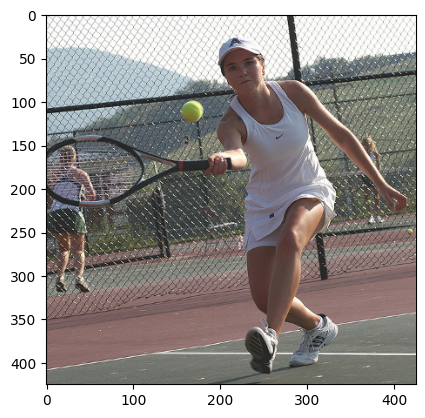

In [11]:
import torchvision.transforms as T
preprocess = T.Compose([
             T.ToTensor(),
             T.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])


train_img_dir  = os.path.join(args.data_dir, 'training_split', 'training_images')
image_path = train_img_dir + '/train-9039_nsd-66847.png'
image = Image.open(image_path)
plt.imshow(image)
img = preprocess(image)
print(img.shape)
patch_size = 14

size_im = (
    img.shape[0],
    int(np.ceil(img.shape[1] / patch_size) * patch_size),
    int(np.ceil(img.shape[2] / patch_size) * patch_size),
)
paded = torch.zeros(size_im)
paded[:, : img.shape[1], : img.shape[2]] = img
img = paded

imgs = img[None, :,:,:]

h = img.shape[-2] // patch_size
w = img.shape[-1] // patch_size

# train_loader, val_loader = fetch_nsd_dataloader(args, args.batch_size, train='train')
# test_loader = fetch_nsd_dataloader(args, args.batch_size, train='test')

In [24]:
'''
This model was trained using the following:

python main.py --readout_res 'faces' --save_model 1 --enc_output_layer 2
'''

readout_res = 'rois_all'
sub = '01'
enc_output_layer = 1

arch = 'dinov2_q_transformer'

dec_attn_weights_all = []

for run in range(14, 15):
    print(f'Run {run}')
    model_path = f'./results/nsd_test/{arch}/subj_{sub}/{readout_res}/enc_{enc_output_layer}/run_{run}/'
    model, args = load_model_path(model_path)

    enc_output, enc_attn_weights, dec_output, dec_attn_weights = \
      extract_transformer_features(model, images.to(device), enc_layers=0, dec_layers=1)


    dec_attn_weights_all.append(dec_attn_weights[0].reshape(-1,50,h, w).detach().cpu().numpy())

dec_attn_weights_all = np.array(dec_attn_weights_all)


Run 14


Using cache found in /home/ha2366/.cache/torch/hub/facebookresearch_dinov2_main


In [10]:
dec_attn_weights_all.shape

(1, 32, 50, 31, 31)

In [25]:
dec_attn_weights = dec_attn_weights_all.mean(0)

In [26]:
args.rois_ind = [0, 1, 2, 3, 4]

roi_name_maps, lh_challenge_rois, rh_challenge_rois = roi_maps(args.data_dir)

lh_challenge_rois_s = []
rh_challenge_rois_s = []

lh_roi_names = []
rh_roi_names = []

for r in args.rois_ind:

    #len(roi_name_maps[args.rois_ind])
    #args.roi_nums = len(roi_name_maps[args.rois_ind])

    lh_rois = torch.tensor(lh_challenge_rois[r]).to(args.device)  # -1
    rh_rois = torch.tensor(rh_challenge_rois[r]).to(args.device)  # -1

    
    for i in range(1, len(roi_name_maps[r])):
        lh_challenge_rois_s.append(torch.where(lh_rois == i, 1, 0))
        rh_challenge_rois_s.append(torch.where(rh_rois == i, 1, 0))

        lh_roi_names.append(roi_name_maps[r][i])
        rh_roi_names.append(roi_name_maps[r][i])

lh_challenge_rois_s = torch.vstack(lh_challenge_rois_s)
rh_challenge_rois_s = torch.vstack(rh_challenge_rois_s)

print('lh_challenge_rois_s.shape:', lh_challenge_rois_s.shape)
print('rh_challenge_rois_s.shape:', rh_challenge_rois_s.shape)

lh_challenge_rois_0 = torch.where(lh_challenge_rois_s.sum(0) == 0, 1, 0)
rh_challenge_rois_0 = torch.where(rh_challenge_rois_s.sum(0) == 0, 1, 0)

lh_challenge_rois_s = torch.cat((lh_challenge_rois_s, lh_challenge_rois_0[None,:]), dim=0)
rh_challenge_rois_s = torch.cat((rh_challenge_rois_s, rh_challenge_rois_0[None,:]), dim=0)

print('lh_challenge_rois_s.shape:', lh_challenge_rois_s.shape)
print('rh_challenge_rois_s.shape:', rh_challenge_rois_s.shape)

args.lh_vs = lh_challenge_rois_s.shape[1]
args.rh_vs = rh_challenge_rois_s.shape[1]   

if args.readout_res == 'voxels':
    args.num_queries = args.lh_vs + args.rh_vs
elif args.readout_res == 'rois_all':
    args.num_queries = lh_challenge_rois_s.shape[0] + rh_challenge_rois_s.shape[0]


lh_challenge_rois_s.shape: torch.Size([24, 19004])
rh_challenge_rois_s.shape: torch.Size([24, 20544])
lh_challenge_rois_s.shape: torch.Size([25, 19004])
rh_challenge_rois_s.shape: torch.Size([25, 20544])


In [37]:
lh_challenge_rois_0.sum()

tensor(5350, device='cuda:0')

In [13]:
readout_res_all = ['visuals','bodies','faces','places','words','streams_inc']
roi_name_ind = readout_res_all.index(readout_res)

# Load the ROI classes mapping dictionaries
roi_mapping_files = ['mapping_prf-visualrois.npy', 'mapping_floc-bodies.npy',
    'mapping_floc-faces.npy', 'mapping_floc-places.npy',
    'mapping_floc-words.npy', 'mapping_streams.npy']
roi_name_maps = []
for r in roi_mapping_files:
    roi_name_maps.append(np.load(os.path.join(args.data_dir, 'roi_masks', r),
        allow_pickle=True).item())

# Load the ROI brain surface maps
lh_challenge_roi_files = ['lh.prf-visualrois_challenge_space.npy',
    'lh.floc-bodies_challenge_space.npy', 'lh.floc-faces_challenge_space.npy',
    'lh.floc-places_challenge_space.npy', 'lh.floc-words_challenge_space.npy',
    'lh.streams_challenge_space.npy']
rh_challenge_roi_files = ['rh.prf-visualrois_challenge_space.npy',
    'rh.floc-bodies_challenge_space.npy', 'rh.floc-faces_challenge_space.npy',
    'rh.floc-places_challenge_space.npy', 'rh.floc-words_challenge_space.npy',
    'rh.streams_challenge_space.npy']
lh_challenge_rois = []
rh_challenge_rois = []
for r in range(len(lh_challenge_roi_files)):
    lh_challenge_rois.append(np.load(os.path.join(args.data_dir, 'roi_masks',
        lh_challenge_roi_files[r])))
    rh_challenge_rois.append(np.load(os.path.join(args.data_dir, 'roi_masks',
        rh_challenge_roi_files[r])))
    
    
lh_rois = torch.tensor(lh_challenge_rois[args.rois_ind]).to(args.device)  # -1
rh_rois = torch.tensor(rh_challenge_rois[args.rois_ind]).to(args.device)  # -1

lh_challenge_rois_s = []
rh_challenge_rois_s = []
for i in range(args.roi_nums):
    lh_challenge_rois_s.append(torch.where(lh_rois == i, 1, 0))
    rh_challenge_rois_s.append(torch.where(rh_rois == i, 1, 0))

lh_challenge_rois_s = torch.vstack(lh_challenge_rois_s)
rh_challenge_rois_s = torch.vstack(rh_challenge_rois_s)

ValueError: 'rois_all' is not in list

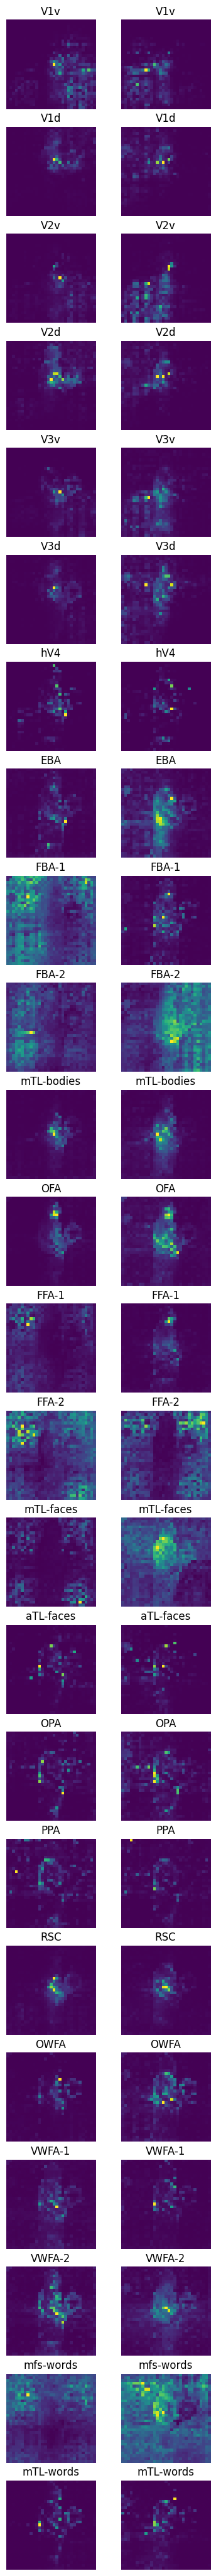

In [27]:
#plt.imshow(dec_attn_weights[0][1])
im_ind = 22

fig = plt.figure(figsize= (4.5, (2.29*(lh_challenge_rois_s.shape[0]-1))))
# and we add one plot per reference point
gs = fig.add_gridspec(lh_challenge_rois_s.shape[0], 2)
fig.subplots_adjust(wspace=0.1, hspace=0.2)

for i in range(2):
    for j in range(1,len(lh_roi_names)+1):
        ax = plt.subplot(gs[j-1, i])
        ax.imshow(dec_attn_weights[im_ind][(i*25) + j])
        plt.axis('off')
        if i == 0:
            ax.set_title(lh_roi_names[j-1])
        elif i == 1:
            ax.set_title(rh_roi_names[j-1])
#fig.savefig("../figures/faces.png", bbox_inches='tight', dpi=300)

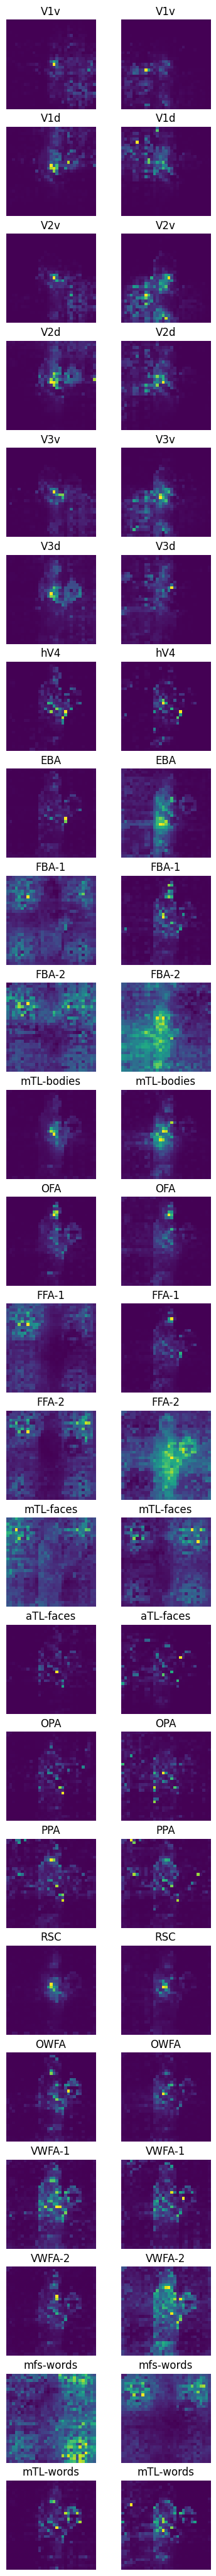

In [63]:
#plt.imshow(dec_attn_weights[0][1])
im_ind = 22

fig = plt.figure(figsize= (4.5, (2.29*(lh_challenge_rois_s.shape[0]-1))))
# and we add one plot per reference point
gs = fig.add_gridspec(lh_challenge_rois_s.shape[0], 2)
fig.subplots_adjust(wspace=0.1, hspace=0.2)

for i in range(2):
    for j in range(1,len(lh_roi_names)+1):
        ax = plt.subplot(gs[j-1, i])
        ax.imshow(dec_attn_weights[im_ind][(i*25) + j])
        plt.axis('off')
        if i == 0:
            ax.set_title(lh_roi_names[j-1])
        elif i == 1:
            ax.set_title(rh_roi_names[j-1])
#fig.savefig("../figures/faces.png", bbox_inches='tight', dpi=300)

In [29]:
images[0].shape

torch.Size([3, 434, 434])

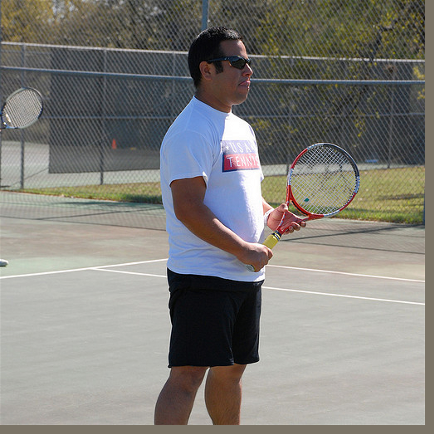

In [71]:
import torch
import torchvision.transforms as transforms

mean = [0.485, 0.456, 0.406]  # Mean used for normalization
std = [0.229, 0.224, 0.225]  # Standard deviation used for normalization

def denormalize(tensor, mean, std):
    """Denormalizes a tensor image."""
    # Create an inverse transform
    inv_normalize = transforms.Normalize(
        mean=[-m / s for m, s in zip(mean, std)],
        std=[1 / s for s in std]
    )

    # Apply the inverse transform
    return inv_normalize(tensor)


# Denormalize the tensor
denormalized_tensor = denormalize(images[im_ind], mean, std)
# Convert the tensor to a PIL Image
to_pil = transforms.ToPILImage()
image = to_pil(denormalized_tensor)
image

(425, 425, 3)
(434, 434, 3)
255.0


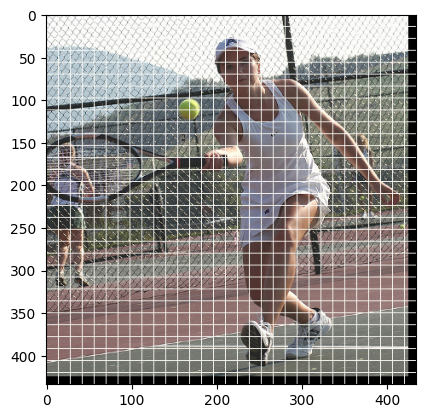

In [20]:
# plot a grid on the iamge to show different patches

from PIL import Image, ImageDraw

train_img_dir  = os.path.join(args.data_dir, 'training_split', 'training_images')
image_path = train_img_dir + '/train-9039_nsd-66847.png'
image = Image.open(image_path)

#img = Image.fromarray(img_with_dots)
# new_size = (608, 912)
# image = img.resize(new_size)
image = np.array(image)

print(image.shape)
init_image_size = image.shape
patch_size = 14


# Padding the image with zeros to fit multiple of patch-size
size_im = (
    int(np.ceil(image.shape[0] / patch_size) * patch_size),
    int(np.ceil(image.shape[1] / patch_size) * patch_size),
    image.shape[2]
)
print(size_im)
paded = np.zeros(size_im)
paded[: image.shape[0], : image.shape[1], :] = image
print(np.max(paded))
image = Image.fromarray(np.uint8(paded))
    

# Draw some lines
draw = ImageDraw.Draw(image)
y_start = 0
y_end = image.size[1]

#h_featmap,w_featmap  (57, 38)

step_count_h, step_count_w = 31, 31

step_size_w = int(image.size[0] / step_count_w)
step_size_h = int(image.size[1] / step_count_h)

for x in range(0, image.size[0], step_size_w):
    line = ((x, y_start), (x, y_end))
    draw.line(line, fill=(251, 250,245))

x_start = 0
x_end = image.size[0]

for y in range(0, image.size[1], step_size_h):
    line = ((x_start, y), (x_end, y))
    draw.line(line, fill=(251, 250,245))


image.save('./results/image_with_grid_orig.png', dpi=(300, 300))
plt.imshow(np.array(image))


In [16]:
434/14


31.0

/tmp/ipykernel_216210/3049653592.py:47: RuntimeWarning: Mean of empty slice
  lh_fsaverage = np.nanmean(lh_fsaverage, 0)
/tmp/ipykernel_216210/3049653592.py:48: RuntimeWarning: Mean of empty slice
  rh_fsaverage = np.nanmean(rh_fsaverage, 0)


Setting _INKSCAPE_GC=disable as a workaround for broken libgc
Unable to init server: Could not connect: Connection refused
(ld-linux-x86-64.so.2:246108): glibmm-WARNING **: 12:36:45.711: Failed to wrap object of type 'GtkRecentManager'. Hint: this error is commonly caused by failing to call a library init() function.
(ld-linux-x86-64.so.2:246108): Pango-CRITICAL **: 12:36:45.712: pango_font_get_hb_font: assertion 'PANGO_IS_FONT (font)' failed
(ld-linux-x86-64.so.2:246108): GLib-GObject-CRITICAL **: 12:36:45.712: g_object_unref: assertion 'G_IS_OBJECT (object)' failed
(ld-linux-x86-64.so.2:246108): Pango-CRITICAL **: 12:36:45.720: pango_font_get_hb_font: assertion 'PANGO_IS_FONT (font)' failed
(ld-linux-x86-64.so.2:246108): GLib-GObject-CRITICAL **: 12:36:45.720: g_object_unref: assertion 'G_IS_OBJECT (object)' failed
** (ld-linux-x86-64.so.2:246108): WARNING **: 12:36:45.724: SPObject::updateDisplay(SPCtx *ctx, unsigned int flags) : throw in ((SPObjectClass *) G_OBJECT_GET_CLASS(this))

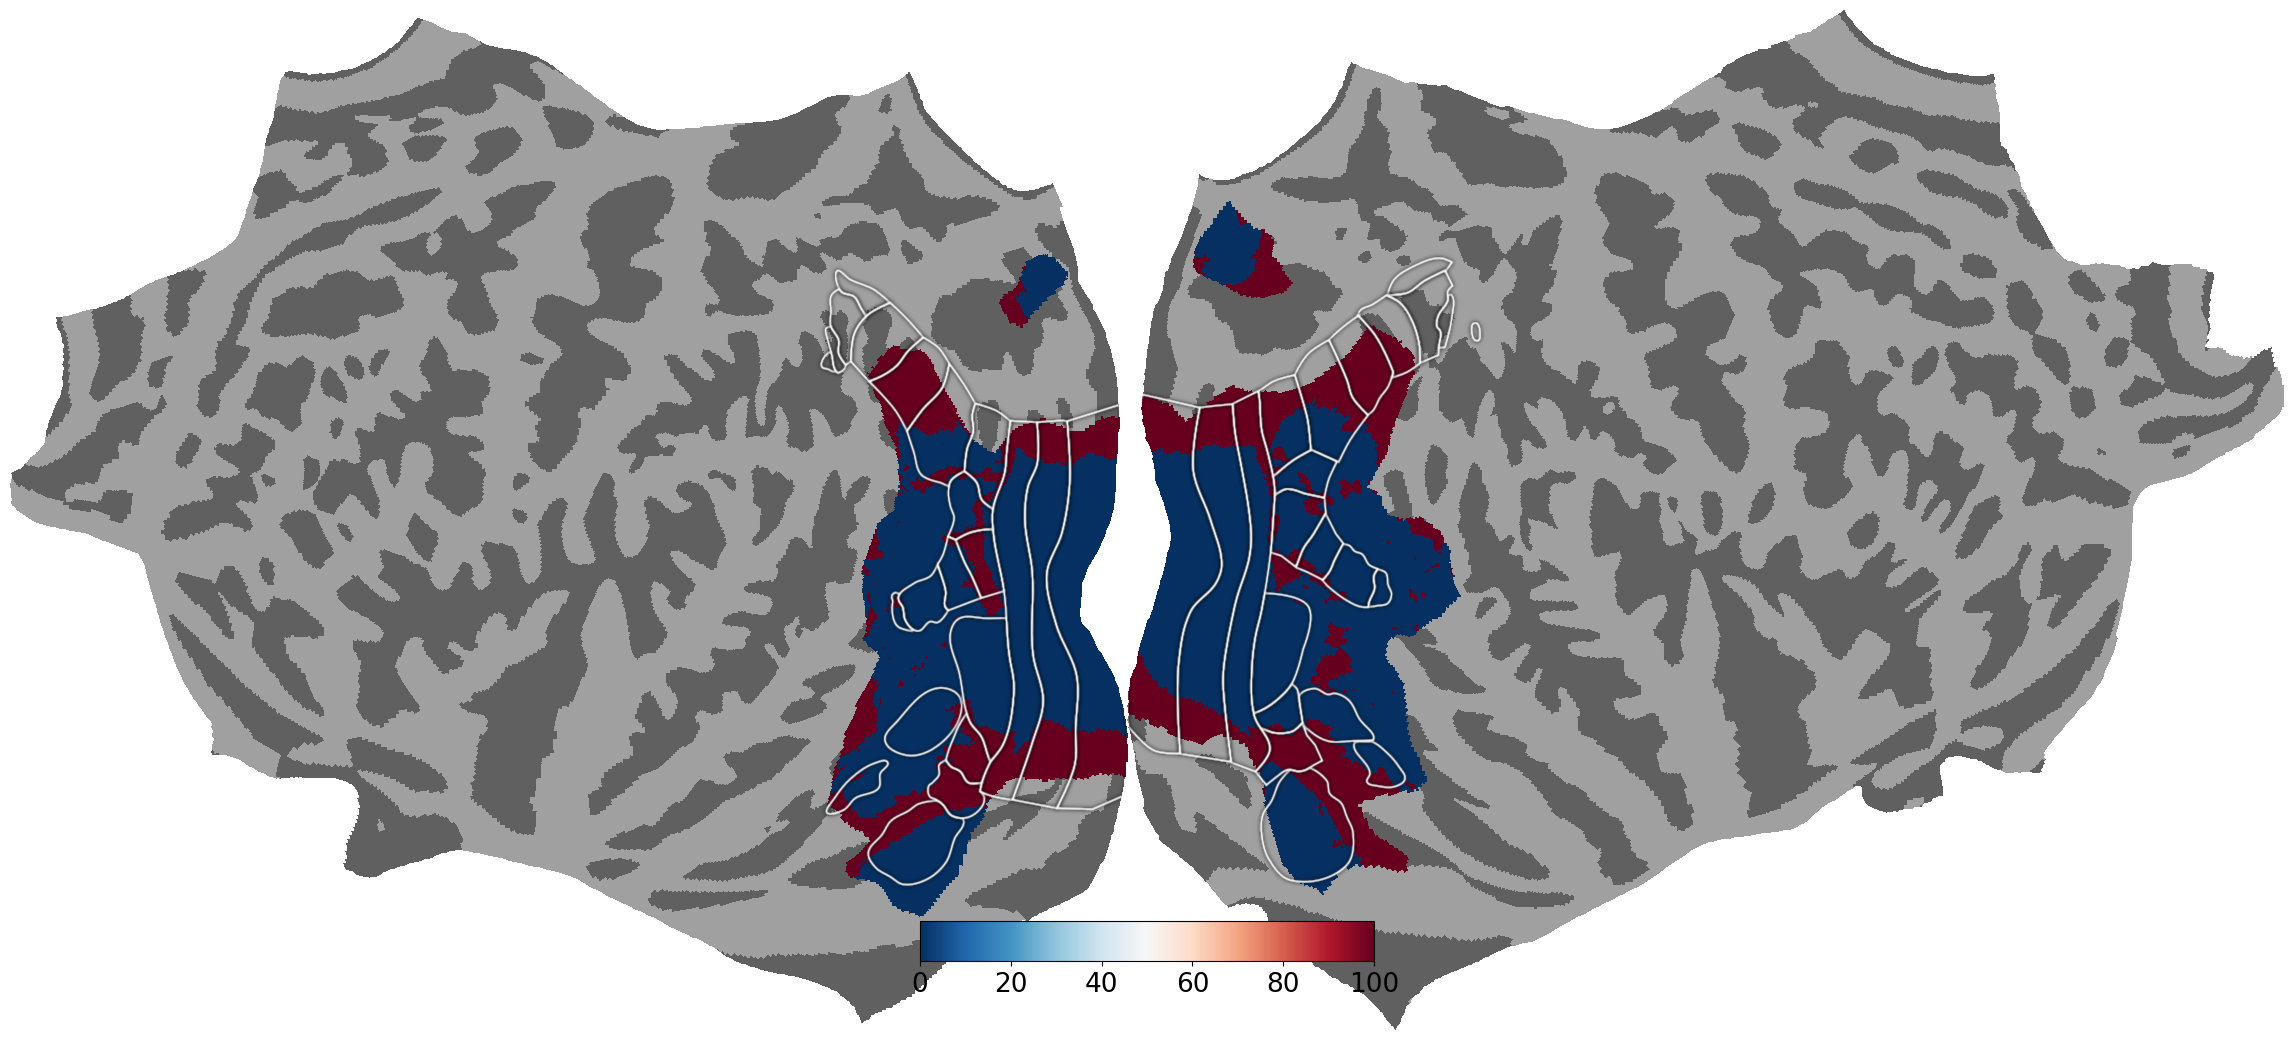

In [39]:
"""Plot data on a flattened brain surface using pycortex.

"""

import os
from copy import copy
import numpy as np
from matplotlib import pyplot as plt
import cortex
import cortex.polyutils

# =============================================================================
# Map the data to fsaverage space
# =============================================================================
# pycortex requires data in fsaverage space, so here you map the vertices from
# Challenge space into fsaverage space. The voxels not used in the Challenge
# are given NaN values, so that pycortex ignores them for the plotting.
# "ls_scores" and "rh_scores" are lists with 8 elements, one for each subject.
# These elements consist of vectors of length N, where N is the vertex amount
# for each subject and hemisphere, and each vector component consists of the
# prediction accuracy for that vertex.

#challenge_data_dir = '../algonauts_2023_challenge_data'
challenge_data_dir = '/engram/nklab/algonauts/algonauts_2023_challenge_data/'
lh_fsaverage = []
rh_fsaverage = []
subjects = [1]
for s, sub in enumerate(subjects):
    lh_mask_dir = os.path.join(challenge_data_dir, 'subj'+format(sub, '02'),
        'roi_masks', 'lh.all-vertices_fsaverage_space.npy')
    rh_mask_dir = os.path.join(challenge_data_dir, 'subj'+format(sub, '02'),
        'roi_masks', 'rh.all-vertices_fsaverage_space.npy')
    lh_fsaverage_all_vertices = np.load(lh_mask_dir)
    rh_fsaverage_all_vertices = np.load(rh_mask_dir)
    lh_fsavg = np.empty((len(lh_fsaverage_all_vertices)))
    lh_fsavg[:] = np.nan
    lh_fsavg[np.where(lh_fsaverage_all_vertices)[0]] = lh_challenge_rois_0.cpu() #lh_scores[s]
    lh_fsaverage.append(copy(lh_fsavg))
    rh_fsavg = np.empty((len(rh_fsaverage_all_vertices)))
    rh_fsavg[:] = np.nan
    rh_fsavg[np.where(rh_fsaverage_all_vertices)[0]] = rh_challenge_rois_0.cpu() #rh_scores[s]
    rh_fsaverage.append(copy(rh_fsavg))
    
    break

# Average the scores across subjects
lh_fsaverage = np.nanmean(lh_fsaverage, 0)
rh_fsaverage = np.nanmean(rh_fsaverage, 0)


# =============================================================================
# Plot parameters for colorbar
# =============================================================================
plt.rc('xtick', labelsize=19)
plt.rc('ytick', labelsize=19)


# =============================================================================
# Plot the results on brain surfaces
# =============================================================================
subject = 'fsaverage'
data = np.append(lh_fsaverage, rh_fsaverage) * 100
vertex_data = cortex.Vertex(data, subject, cmap='RdBu_r', vmin=0, vmax=100)
cortex.quickshow(vertex_data, with_curvature=True)
plt.savefig('my_plot.png', dpi=300) 
plt.show()

